### Compiling the C++ source code.

- In a Linux/Unix terminal move to the folder containing the source code files:
  - main.cpp
  - network.h 
  - makefile

- and run the following command:

```
make
```

- The code will compile correctly (do not worry about the warnings!)

###  Run the Python script generator 

- Script: https://github.com/marsgr6/ann/blob/master/cpp_ann/script_generator_example.py)

- Running the script:

```
    python script_generator_example.py > run_example.sh
```

- Details of the script:

```python
"""
  This code generates a unix bash script  
  for running the C++ generated program 
  with the selected set of parameters for 
  p: patterns (integer)
  K: connectivity (integer)
  nns: number of modules (list of integers)
  topos: topologies (list from ['r', 'c', 'x'])
    r: Ring, c: Cross, 'x': X topologies
  ws: omega values (list of floats)

  Example:
    python script_generator_example.py > run_example.sh
"""
```

- The following part of the script creates the combination of parameter to run the C++ program.

```python
p = 150  # patterns
K = 240

nns = [10, 15]  # 1, 10 and 15 ensemble modules
topos = ['r', 'c']  # r: ring topology, c: cross topology
ws = [0.5, 1]  # omega: random connection ratio

advance = 0

# Total number of times that the cpp program will be executed 
# according to the combination of paramters
# p // nn: pattern subsetting assigned to modules
# len(topos): number of topologies to check
# len(ws): number of values of random connection ratios to check
# Above combination is checked for different values of modules: nns
runs = sum([p // nn * len(topos) * len(ws) for nn in nns])

```

- For the above parameters runs is a 100, i.e. the C++ program will be run a 100 times.

- **p // nn** is the pattern subsetting for each module, times the topologies to test, **topos**, times the $\omega$, **ws**, values to test. For both values of ensemble modules, **nns**, a list of [60, 40] runs, a total of 100 executions, will be carried out.

- **Note** that running the cpp program for 100 parameter combination (100 executions) may take 8 to 12 hours depending on the computer configuration and operating system. 

###  Run the script which calls the C++ program 

- Script: https://github.com/marsgr6/ann/blob/master/cpp_ann/run_example.sh

- Make run_example.sh executable: 

```
    chmod +x run_example.sh
```

- Execute:

```
    ./run_example.sh

```

- A list of txt files for each execution of the C++ program will be found in the home (.) directory.

### Processing the output files 

- Python 3, requiring numpy, matplotlib and seaborn libraries, is used to process the output files.

- The following code requires to specify a path to the folder where the output txt files, from running the cpp program, are located. 

- The output files of the 100 executions detailed above are moved to a folder named: example_results.

  - Results folder: https://github.com/marsgr6/ann/tree/master/cpp_ann/example_results 
  
- **The output files are processed as follows in the next cells.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
sns.set_context("poster", font_scale=1.15)

In [2]:
def proccess_results(nn, p, K, w, t='r', th_r=0.5, path_prefix='.', 
                     plot=False, path_folder="patterns"):
    """
    Process and plot results from the text files 
    generated from the cpp program.
    nn: number of modules in the ensemble
    p: number of patterns
    K: connectivity degree
    w: random shortcuts ratio (omega)
    t: topology (in ['r', 'c', 'x'])
    th_r: recovery threshold
    path_prefix: path where text files are located
    """
    
    # Generate path and files names from parameters
    paths = []
    for i in range(p//nn):
        paths += [path_prefix+"N89420K"+ str(K//nn)+"w"+w+
                  "a0.2258b1Trt0.656rho0.7np0.0time100p1P"+
                  str((i+1)*nn)+"pi6x100w263h340TY"+t+"SNS"+
                  str(i+1)+"NN"+str(nn)+"PW"+path_folder+".txt"]
    #print(paths)
    
    topos = 'Ring, $\omega=$'
    if t == 'c':
        topos = 'Cross, $\omega=$'
    if t == 'x':
        topos = 'X, $\omega=$'  

    
    # Macroscopic measures 
    start_i = 0
    M = []
    P_l = []
    R = []
    alpha_R = []
    
    
    # Load files and calculate measures
    
    # This is true if starts in pattern 1        
    if nn == 1:
        mi = np.loadtxt(paths[0], delimiter=',')[1]
        M = [mi]
        P_l = [1]
        R = [1]
        alpha_R = [1/K]
        start_i = 1        
        
        
    for i in range(start_i,p//nn):
        
        mi = np.abs(np.loadtxt(paths[i], delimiter=',')[:,1])
        
        if not start_i:
            ss = i+1
            iis = []
            for ni in range(nn):
                iis += list(range(ni*(nn*ss)+ni*ss, ni*(nn*ss)+ni*ss+ss))
        
            mi = np.abs(np.loadtxt(paths[i], delimiter=',')[:,1][iis])

        P_l += [len(mi)]
        M += [np.mean(mi)]
        P_r = len(np.where(mi > th_r)[0])
        R += [P_r / P_l[-1]]
        alpha_R += [P_r / K]

    max_alpha = np.where(alpha_R == np.max(alpha_R))[0][-1]
    
    # Plot curves
    
    if plot:
        plt.plot(np.array(P_l), M, ':ob', label="M")
        plt.plot(np.array(P_l), R, ':Pg', label="R")
        plt.plot(np.array(P_l), alpha_R, ':xr', label=r'$\alpha_R$')
        plt.axvline(x=max_alpha*nn + P_l[0], color='r')
        plt.text(max_alpha*nn + P_l[0], 0.2, 
                 'R='+str(int(P_l[max_alpha]*R[max_alpha]))+
                 '/'+str(max_alpha*nn + P_l[0]), 
                 fontsize=24)
        ly = plt.ylim(0,1)
        plt.xlabel(r'$P_l$', fontsize=32)
        plt.legend(frameon=False)
        plt.title('\n'+topos+w+', n='+str(nn))
        #plt.show()

    return (max_alpha*nn + P_l[0])*R[max_alpha] / K, P_l, P_r, M, R, alpha_R


def plot_results_8_top(paths, thr=0.5, ii=0, ff=8, fs=(28,6)):
    """
    Process and plots microscopic results from the
    text files generated from the cpp program.
    paths: list with path to files
    thr: recovery threshold
    ii and ff: lower and upper limits of panels to plot.
    """
        
    results = []
    
    for path in paths[ii:ff]:
        
        nn = int(re.search('NN(.+?)PW', path).group(1))
        ss = int(re.search('SNS(.+?)NN', path).group(1))
        
        iis = []
        
        for ni in range(nn):
            iis += list(range(ni*(nn*ss)+ni*ss, ni*(nn*ss)+ni*ss+ss))
        
        results += [np.abs(np.loadtxt(path, delimiter=',')[:,1][iis])]
    
    cols = len(results)
    rows = 1
    
    fig, ax_array = plt.subplots(rows, cols, figsize=fs)
    ig = 0
    
    for i, ax_row in enumerate(ax_array):
        ax_row.plot(np.abs(results[ig]), 'o')
        ax_row.axhline(y=thr, color='r', linestyle="--", linewidth=3, label=r'$\theta_r$')
        ax_row.set_ylim([-0.02, 1.02])
        r_mean = np.mean(np.abs(results[ig]))
        P_r = len(np.where(np.abs(results[ig]) > thr)[0])
        ax_row.axhline(y=r_mean, color='b', linestyle=":", linewidth=3, label='M')
        print(r_mean)
        ax_row.text(0, 0.3, 'R='+str(P_r)+'/'+str(len(results[ig]))+
                    ', M=' + str(np.round(r_mean, 2)), weight='normal')
        ax_row.set_xlabel(r'$\mu$', fontsize=32)
        ax_row.set_ylabel(r'$m^\mu$', fontsize=32)
        ax_row.legend(frameon=False)
        ig += 1

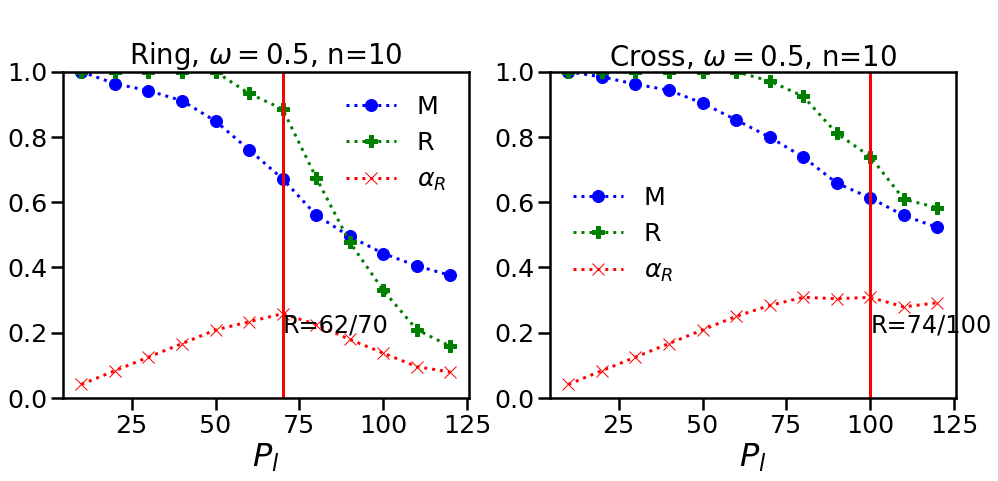

In [3]:
plt.figure(figsize=(16,6))

# Ring topology (left panel)
nn = 10 # modules
p = 120  # patterns learned P_l
K = 240  # Ensemble degree, single module degree is K/nn
th_r = 0.5  # retrieval threshold
w = '0.5'  # omega: random connection ratio
topo = 'r'  #  Topology: r --> ring
path_to_results = './example_results/'  # path where output files are located

plt.subplot(1, 2, 1)
pr = proccess_results(nn, p, K, w, topo, th_r, path_to_results, True)[0]

# Cross topology (right panel)
nn = 10 # modules
p = 120  # patterns learned P_l
K = 240
th_r = 0.5
w = '0.5'
topo = 'c'

plt.subplot(1, 2, 2)
pr = proccess_results(nn, p, K, w, topo, th_r, path_to_results, True)[0]

0.6716755571428571
0.6132438800000001


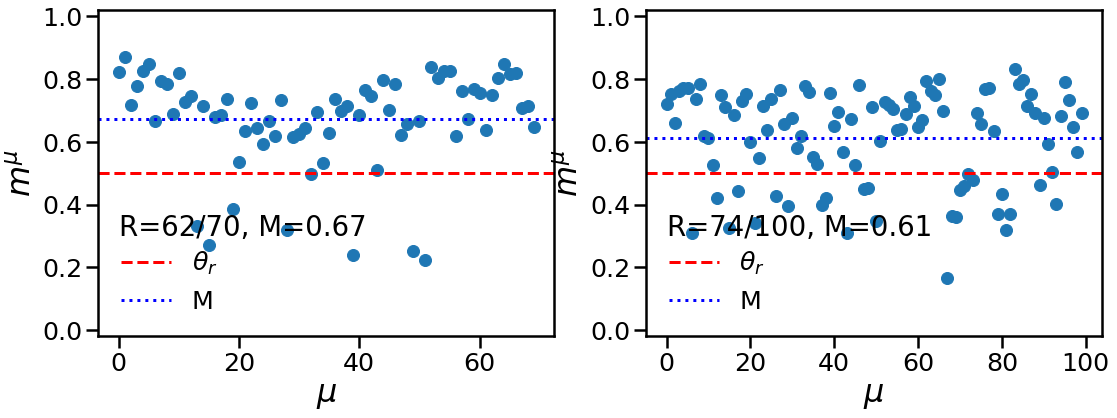

<Figure size 1296x432 with 0 Axes>

In [4]:
"""
The files in paths corresponds to the point 
of the red vertical line in the panels above.

A microscopic value of m_i is plotted for each
pattern/fingerprint in the file.
""" 

paths = [
    './example_results/N89420K24w0.5a0.2258b1Trt0.656rho0.7np0.0time100p1P70pi6x100w263h340TYrSNS7NN10PWpatterns.txt',
    './example_results/N89420K24w0.5a0.2258b1Trt0.656rho0.7np0.0time100p1P100pi6x100w263h340TYcSNS10NN10PWpatterns.txt',
]

# Ring topology (top panels), first 2 files (ii=0, ff=2)
plot_results_8_top(paths, thr=0.5, ii=0, ff=2, fs=(18,6))

# Cross topology (bottom panels), next 2 files (ii=2, ff=4)
plot_results_8_top(paths, thr=0.5, ii=2, ff=4, fs=(18,6))

- **The instructions above can be followed to run and process the results presented in the submitted paper.**